# Cart page experiment - MDE Analysis

### Assumptions
- We will only measure results for users that had at least 1 session throughout the experiment period
- The split is 50/50 Control/Treatment

In [1]:
import pandas as pd
import numpy as np

# Avoids needing to restart kernel when modules are changed
%load_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

import os
import sys
from statsmodels.stats.power import tt_ind_solve_power
from datetime import date, datetime, timedelta
from scipy.stats import norm
import math

## Viz parameters
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", None)
palette_glovo = ["#00A082", "#F2CC38", "#313131", "#8080E7", "#DB6668", "#A6A6A6", "#00A083", "#F2CC39", "#313132", "#8080E8", "#DB6669", "#A6A6A7"]
sns.set_palette(palette_glovo)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Montserrat'
sns.set_style("white")
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 8, 'axes.titlesize': 12})
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)
pd.options.display.max_colwidth = 100

In [2]:
#replace with your path
base_path = '/Users/mathias.cardarello/Documents/GitHub/customer-data-analytics/'

sys.path.insert(1,os.path.join(base_path, 'General/AB-tests/MDE'))
sys.path.insert(2,os.path.join(base_path, 'General/AB-tests'))

In [3]:
from fenix.statistical_tests import relative_ttest as t_test
from fenix.run_experiment import ExperimentConfig, MDEConfig, ExperimentRunner
from fenix.statistical_tests.stattools import StatisticalResult
from fenix.tools.helpfuncs import mde_visualization
from fenix.tools.helpfuncs import adjusted_alpha_multiple_comparison

import transformations.transformation as tr
import fenix.visual.graphs
import fenix.tools.hashing as hashing

## Load data

In [ ]:
"""
---- Groceries Store view -> Groceries Order

with
groceries_stores AS (
    SELECT sa.store_address_id,
            sa.store_id
    FROM delta.partner_stores_odp.store_addresses_v2 sa
        LEFT JOIN delta.partner_stores_odp.stores_v2 s ON sa.store_id = s.store_id
    WHERE s.store_subvertical2 = 'Groceries'
      AND s.p_end_date IS NULL
      AND sa.p_end_date IS NULL
),

customer_exposures_dates as (
select
    customer_id,
    min(p_creation_date) as exposure_date
FROM
    delta.customer_behaviour_odp.dynamic_sessions_v1 AS ds
INNER JOIN UNNEST(ds.visited_store_address_ids) AS unnested(store_address_id) ON TRUE
    INNER JOIN groceries_stores gs ON unnested.store_address_id = gs.store_address_id

where p_creation_date BETWEEN DATE_ADD('DAY', -30, DATE(CURRENT_DATE)) AND DATE_ADD('DAY', 0, DATE(CURRENT_DATE))
--where p_creation_date BETWEEN DATE('2024-04-01') AND DATE('2024-05-01')
and count_ce__store_accessed > 0 
group by 1
),

sessions_with_groceries_store_accessed as (
select
    dynamic_session_id,
    p_creation_date,
    customer_id
FROM
    delta.customer_behaviour_odp.dynamic_sessions_v1 AS ds
INNER JOIN UNNEST(ds.visited_store_address_ids) AS unnested(store_address_id) ON TRUE
    INNER JOIN groceries_stores gs ON unnested.store_address_id = gs.store_address_id

where p_creation_date BETWEEN DATE_ADD('DAY', -30, DATE(CURRENT_DATE)) AND DATE_ADD('DAY', 0, DATE(CURRENT_DATE))
and count_ce__store_accessed > 0 
),

sessions_with_groceries_order_created as (
SELECT
      oc.dynamic_session_id
    , oc.customer_id
    , COUNT(DISTINCT oc.order_id) AS count_orders_created_in_session
FROM delta.customer_behaviour_odp.enriched_custom_event__order_created_v3 AS oc
    INNER JOIN groceries_stores
        ON groceries_stores.store_id = oc.store_id
WHERE True
    AND oc.p_creation_date BETWEEN DATE_ADD('DAY', -30, DATE(CURRENT_DATE)) AND DATE_ADD('DAY', 0, DATE(CURRENT_DATE))
GROUP BY 1,2
),

groceries_orders as (
SELECT 
        o.customer_id
        , o.order_id
        , o.order_total_purchase_eur          
        , o.p_creation_date
FROM delta.central_order_descriptors_odp.order_descriptors_v2 AS o
    INNER JOIN groceries_stores s
        ON s.store_id = o.store_id 
WHERE True
    AND o.p_creation_date BETWEEN DATE_ADD('DAY', -30, DATE(CURRENT_DATE)) AND DATE_ADD('DAY', 0, DATE(CURRENT_DATE))

),

observations_from_sessions_stage as (
select
    sa.customer_id,
    sa.p_creation_date                                                       AS p_event_date,
    COUNT(DISTINCT sa.dynamic_session_id)                                    AS sessions_store_accessed,
    COUNT(DISTINCT oc.dynamic_session_id)                                    AS sessions_with_orders_created,
    COUNT(go.order_id)                                                       AS groceries_orders,
    SUM(go.order_total_purchase_eur)                                         AS sum_purchase_eur
 /*
    COUNT(DISTINCT CASE WHEN count_ce__store_accessed > 0
                            THEN ds.dynamic_session_id
                        END)                                        AS sessions_store_accessed,
    COUNT(DISTINCT CASE WHEN count_orders_created_in_session > 0
                            THEN ds.dynamic_session_id
                        END)                                        AS sessions_with_orders_created */
FROM
    sessions_with_groceries_store_accessed AS sa
    LEFT JOIN sessions_with_groceries_order_created AS oc ON sa.dynamic_session_id=oc.dynamic_session_id AND sa.customer_id=oc.customer_id
    LEFT JOIN groceries_orders AS go ON go.customer_id=go.customer_id AND sa.p_creation_date=go.p_creation_date
WHERE
    TRUE
    AND sa.p_creation_date BETWEEN DATE_ADD('DAY', -30, DATE(CURRENT_DATE)) AND DATE_ADD('DAY', 0, DATE(CURRENT_DATE))
GROUP BY
        1,2
),

observations_from_sessions as (
SELECT t1.customer_id, 
       t1.p_event_date, 
       t2.obs_name, 
       t2.obs_value
FROM observations_from_sessions_stage t1
CROSS JOIN unnest (
  array['sessions_store_accessed', 'sessions_with_orders_created', 'sum_purchase_eur', 'groceries_orders'],
  array[sessions_store_accessed, sessions_with_orders_created, sum_purchase_eur, groceries_orders]
) t2 (obs_name, obs_value)
),

observations_daily_stage as (
select * from observations_from_sessions
),

observations_daily as (
select
customer_id,
exposure_date,
p_event_date,
obs_name as observation_name,
obs_value as observation_value
from customer_exposures_dates exposures
    left join observations_daily_stage using(customer_id)
where obs_value != 0
and (p_event_date >= exposure_date or p_event_date is null)
),

observations_daily_with_exposure_date as (
select
od.*,
--how many days passed since the first exposure
-- CAST(date_diff('day', exposure_date, p_event_date) as INT) as experiment_days,
CAST(FLOOR(date_diff('day', DATE_ADD('DAY', -30, DATE(CURRENT_DATE)), p_event_date))/7 as INT)+1 as obs_week_index_since_start_date,
--how many days passed since the beginning of the time window before the first exposure
CAST(FLOOR(date_diff('day', DATE_ADD('DAY', -30, DATE(CURRENT_DATE)), exposure_date))/7 as INT)+1 as exposure_week_index_since_start_date
-- CAST(FLOOR(DATE_DIFF('day', date('2024-02-01'), exposure_date) / 7) AS INTEGER)+1 AS time_cutoff
from observations_daily od
),

observations_daily_enriched as (
select
customer_id,
observation_name,
exposure_date,
exposure_week_index_since_start_date,
obs_week_index_since_start_date,
sum(sum(observation_value)) over (
    partition by customer_id, exposure_date, exposure_week_index_since_start_date, observation_name
    order by obs_week_index_since_start_date) as cumsum_observation_value
from observations_daily_with_exposure_date
group by 1,2,3,4,5
),

observations_daily_final as (
select * from observations_daily_enriched
where customer_id is not null
),

-- select from observations_daily_final pivoting in a way to have customer_id, exposure_date, exposure_week_index_since_start_date, obs_week_index_since_start_date as unique indexes, 
-- distinct values of cumsum_observation_value as the columns, and cumsum_observation_value as the values. Fill the missing values with zeros.
observations_pivoted AS (
    SELECT
        f.customer_id,
        f.exposure_date,
        f.exposure_week_index_since_start_date,
        f.obs_week_index_since_start_date,
        SUM(CASE WHEN observation_name = 'sessions_store_accessed' THEN cumsum_observation_value ELSE 0 END) AS sessions_store_accessed,
        SUM(CASE WHEN observation_name = 'sessions_with_orders_created' THEN cumsum_observation_value ELSE 0 END) AS sessions_with_orders_created,
        SUM(CASE WHEN observation_name = 'groceries_orders' THEN cumsum_observation_value ELSE 0 END) AS groceries_orders,
        SUM(CASE WHEN observation_name = 'sum_purchase_eur' THEN cumsum_observation_value ELSE 0 END) AS sum_purchase_eur
    
    FROM observations_daily_final AS f
    INNER JOIN (
                SELECT
                    user_id as customer_id
                FROM "delta"."central_users_odp"."users_v2"
                WHERE True
                    and not user_is_staff
                    and not user_is_glovo_employee
                    and user_type = 'Customer'
            ) as u
                on f.customer_id = u.customer_id
    GROUP BY 1,2,3,4
)

SELECT *
FROM observations_pivoted;



SELECT  exposure_week_index_since_start_date,
        SUM(groceries_orders) as groceries_orders,
        SUM(sum_purchase_eur) as sum_purchase_eur,
        SUM(sessions_with_orders_created)*1.0000/SUM(sessions_store_accessed)*1.0000 as cvr
FROM observations_pivoted
GROUP BY 1
ORDER BY 1
"""

In [78]:
df = pd.read_csv('/Users/mathias.cardarello/Downloads/mde_data.csv')
print(df.shape)
df.head()

(5194855, 8)


,customer_id,exposure_date,exposure_week_index_since_start_date,obs_week_index_since_start_date,sessions_store_accessed,sessions_with_orders_created,groceries_orders,sum_purchase_eur
0,34164,2024-04-27,1,1,2,0,0,0.00000
1,34164,2024-04-27,1,2,3,0,0,0.00000
2,50624,2024-05-11,3,3,1,0,0,0.00000
3,56382,2024-04-25,1,1,3,1,21,677.67000
4,56382,2024-04-25,1,3,5,2,42,0.00000


<Axes: xlabel='exposure_date'>

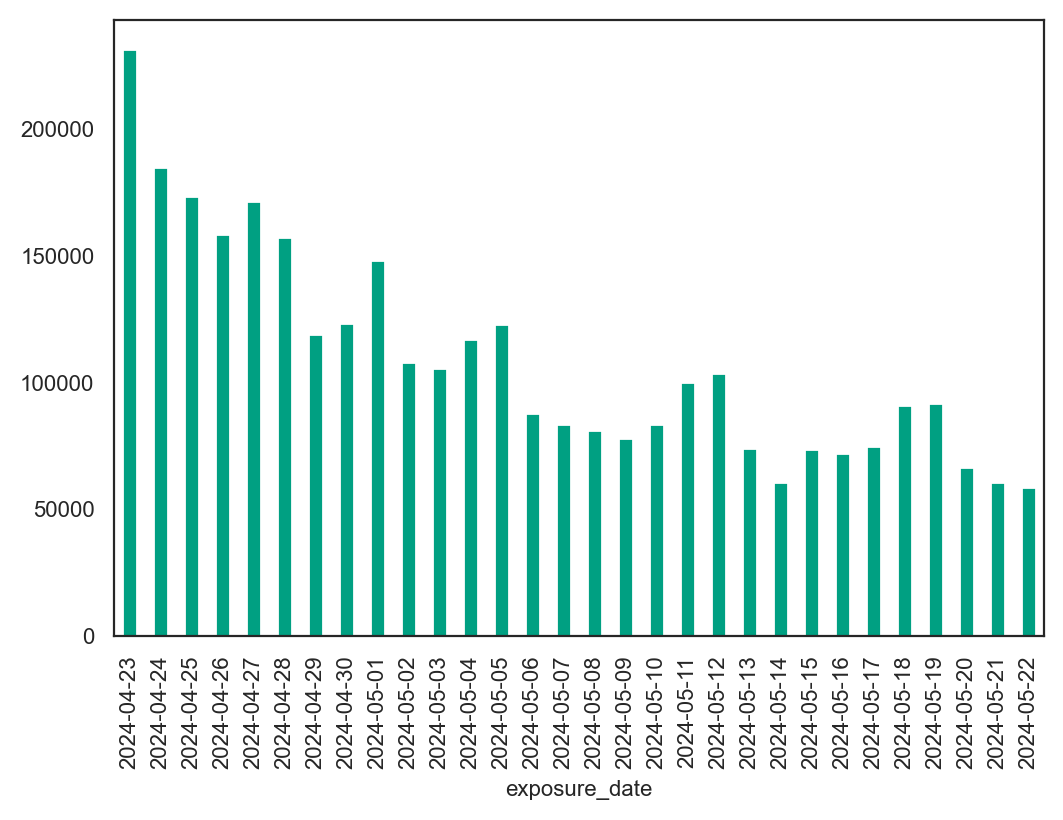

In [5]:
df.groupby('exposure_date').customer_id.nunique().plot(kind='bar')

<Axes: xlabel='exposure_date'>

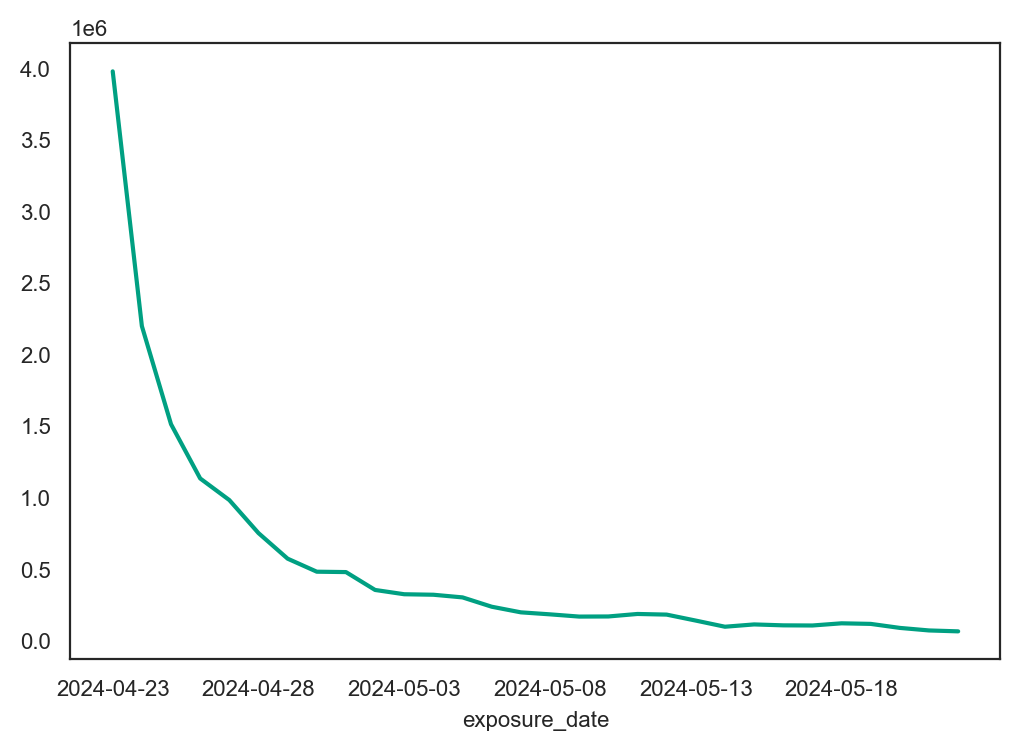

In [32]:
df.groupby('exposure_date').sessions_store_accessed.sum().plot(kind='line')

In [33]:
df['aov']=df['sum_purchase_eur']/df['groceries_orders']
df.describe()

,customer_id,exposure_week_index_since_start_date,obs_week_index_since_start_date,sessions_store_accessed,sessions_with_orders_created,groceries_orders,sum_purchase_eur,aov
count,5194855.00000,5194855.00000,5194855.00000,5194855.00000,5194855.00000,5194855.00000,5194855.00000,1988638.00000
mean,91111369.30223,1.93424,2.67918,3.01018,1.10651,73.06475,1615.91851,19.54964
std,58895679.76030,1.12916,1.26152,3.98740,2.50027,518.60999,12649.64027,15.04574
min,220.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000
25%,34883190.00000,1.00000,2.00000,1.00000,0.00000,0.00000,0.00000,9.43134
50%,90001753.00000,2.00000,3.00000,2.00000,0.00000,0.00000,0.00000,16.65427
75%,148765421.00000,3.00000,4.00000,3.00000,1.00000,14.00000,193.45007,25.16315
max,170240409.00000,5.00000,5.00000,216.00000,92.00000,350567.00000,3147651.68000,999.00000


<Axes: xlabel='exposure_date'>

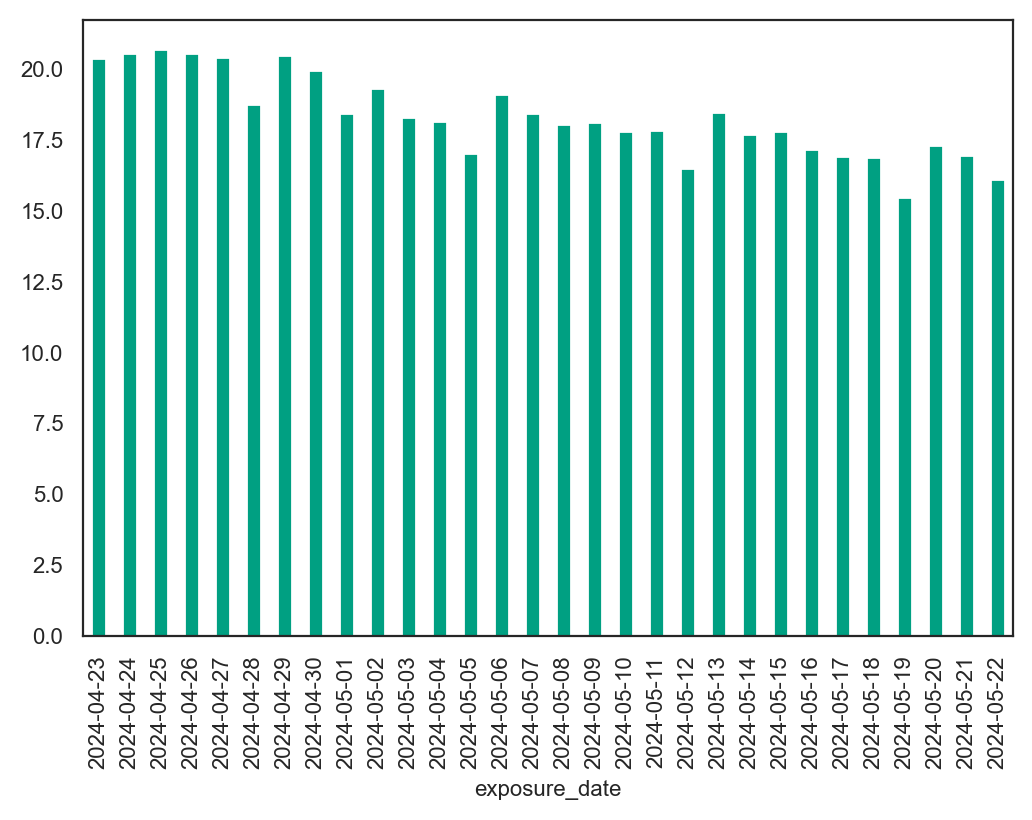

In [34]:
df.groupby('exposure_date').aov.mean().plot(kind='bar')

## Analysis

In [46]:
df.columns

Index(['customer_id', 'exposure_date', 'exposure_week_index_since_start_date', 'obs_week_index_since_start_date', 'sessions_store_accessed', 'sessions_with_orders_created', 'groceries_orders',
       'sum_purchase_eur', 'aov', 'ltho_group', 'exp_group'],
      dtype='object')

In [79]:
# Filter out LTHO group

df['ltho_group'] = df['customer_id'].apply(lambda x: hashing.hashing_function(x, 'a057353b-bdd5-41eb-b62e-d9b488b54367', (49,999)))
df['ltho_group'].value_counts(normalize=True, dropna=False)

ltho_group
variant   0.94999
control   0.05001
Name: proportion, dtype: float64

In [80]:
#filter customers in control = holdout group
df = df[df['ltho_group']=='variant']

In [81]:
sessions_outliers = tr.outliers_detection(df, 'obs_week_index_since_start_date', 'sessions_store_accessed', 'sessions_with_orders_created')
sessions_outliers.head()

,customer_id,exposure_date,exposure_week_index_since_start_date,obs_week_index_since_start_date,sessions_store_accessed,sessions_with_orders_created,groceries_orders,sum_purchase_eur,ltho_group,cmperorder
4143049,143206557,2024-04-23,1,5,99,92,5785,23802.49113,variant,0.92929
2962711,29316145,2024-04-23,1,5,91,82,9034,65134.81928,variant,0.90110
5018197,50510156,2024-04-23,1,5,84,78,6660,130919.57949,variant,0.92857
1906801,62711,2024-04-23,1,5,81,69,1702,19534.47000,variant,0.85185
950208,83942660,2024-04-23,1,5,72,69,477,6578.11000,variant,0.95833


In [82]:
round(sessions_outliers['sessions_store_accessed'].describe(percentiles=[0.0001,0.005,0.05,0.5,0.95,0.99, 0.999, 0.9999]))

count    3100767.00000
mean           3.00000
std            4.00000
min            1.00000
0.01%          1.00000
0.5%           1.00000
5%             1.00000
50%            1.00000
95%            8.00000
99%           18.00000
99.9%         36.00000
99.99%        60.00000
max          216.00000
Name: sessions_store_accessed, dtype: float64

In [83]:
round(sessions_outliers['sessions_with_orders_created'].describe(percentiles=[0.0001,0.005,0.05,0.5,0.95,0.99, 0.999, 0.9999]))

count    3100767.00000
mean           1.00000
std            2.00000
min            0.00000
0.01%          0.00000
0.5%           0.00000
5%             0.00000
50%            0.00000
95%            4.00000
99%           10.00000
99.9%         23.00000
99.99%        37.00000
max           92.00000
Name: sessions_with_orders_created, dtype: float64

In [84]:
outliers_rules = (sessions_outliers['sessions_with_orders_created']>30)|(sessions_outliers['sessions_store_accessed']>40)
outliers_customers = list(set(sessions_outliers[outliers_rules]['customer_id']))

In [85]:
mde_df_clean = df[~df['customer_id'].isin(outliers_customers)]

In [86]:
orders_outliers = tr.outliers_detection(mde_df_clean, 'obs_week_index_since_start_date', 'sum_purchase_eur', 'groceries_orders')
orders_outliers.head()

,customer_id,exposure_date,exposure_week_index_since_start_date,obs_week_index_since_start_date,sessions_store_accessed,sessions_with_orders_created,groceries_orders,sum_purchase_eur,ltho_group,cmperorder
571223,126358051,2024-04-23,1,5,15,13,74931,2183927.63066,variant,0.03431
2171654,4137149,2024-04-24,1,5,23,18,72919,1653132.89000,variant,0.04411
538002,134710380,2024-04-23,1,5,38,28,66055,1075149.37000,variant,0.06144
3451985,66731188,2024-04-23,1,5,35,29,54468,1279598.85000,variant,0.04257
2506781,162978691,2024-04-24,1,5,15,12,52669,1067836.76000,variant,0.04932


In [87]:
round(orders_outliers['sum_purchase_eur'].describe(percentiles=[0.0001,0.005,0.05,0.5,0.95,0.99, 0.999, 0.9999]))

count     844376.00000
mean        3595.00000
std        16488.00000
min            0.00000
0.01%          0.00000
0.5%           3.00000
5%            14.00000
50%          372.00000
95%        14915.00000
99%        58079.00000
99.9%     205853.00000
99.99%    463592.00000
max      2370595.00000
Name: sum_purchase_eur, dtype: float64

In [88]:
round(orders_outliers['groceries_orders'].describe(percentiles=[0.0001,0.005,0.05,0.5,0.95,0.99, 0.999, 0.9999]))

count    844376.00000
mean        163.00000
std         596.00000
min           1.00000
0.01%         1.00000
0.5%          1.00000
5%            1.00000
50%          25.00000
95%         712.00000
99%        2298.00000
99.9%      7207.00000
99.99%    16207.00000
max       74931.00000
Name: groceries_orders, dtype: float64

In [89]:
outliers_rules = (orders_outliers['sum_purchase_eur']>15000)|(orders_outliers['groceries_orders']>700)
outliers_customers_2 = list(set(orders_outliers[outliers_rules]['customer_id']))

In [90]:
mde_df_clean_2 = mde_df_clean[~mde_df_clean['customer_id'].isin(outliers_customers_2)]

In [91]:
print(f"We filtered {(len(outliers_customers)+len(outliers_customers_2))/df['customer_id'].nunique():2%} customers")

We filtered 1.755404% customers


In [95]:
variants_params = {
    'control': 0.34,
    'var_no_upselling': 0.33,
    'var_upselling': 0.33,
    }

In [96]:
SALT = '51231965-8f49-450a-8bea-42d32eefee8f'
# calculate bounds tuples for the smallest group automatically from variants_params
# this function will automatically assign to the variant group the smallest variation
bounds_tuples = hashing.calculate_upper_bounds(variants_params, comparison_between_groups=True)

mde_df_clean_2['exp_group'] = mde_df_clean_2['customer_id'].apply(lambda x: hashing.hashing_function(x, SALT, bounds_tuples))

/var/folders/pr/g6zzn80n6d361nfqklq4dst40000gp/T/ipykernel_19521/3175890518.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mde_df_clean_2['exp_group'] = mde_df_clean_2['customer_id'].apply(lambda x: hashing.hashing_function(x, SALT, bounds_tuples))


In [97]:
# check that the variant group is the smallest
mde_df_clean_2['exp_group'].value_counts(normalize=True, dropna=False)

exp_group
None      0.33862
variant   0.33097
control   0.33040
Name: proportion, dtype: float64

In [98]:
#MDE for primary metrics
#alpha adjusted will be calculated automatically
mde_configuration = {
    "metrics_to_mde": [
                       ('sessions_with_orders_created','sessions_store_accessed'),
                       ('sum_purchase_eur','groceries_orders'),
                       ],
    "experiment_days": [1, 2, 3, 4],
    "compare_between_groups": True,
    #important parameter when you launch a product feature only for new app versions
    "is_new_app_version": False
    }

mde_accuracy = {
    "initial_alpha": 0.05, #false positives
    "beta": 0.20 #false negatives
    }

#the alpha will be adjusted automatically if you have several metrics and several variants
#put compare_between_groups=True if you want to compare metrics between variants as well
mde_accuracy = adjusted_alpha_multiple_comparison(variants_params, mde_configuration , mde_accuracy)

mde_accuracy

We have 3 variants and 2 metrics which translates to 6 total comparisons. The adjusted alpha is 0.008 from the initial alpha of 0.05


{'initial_alpha': 0.05,
 'beta': 0.2,
 'total_comparisons': 6,
 'alpha': 0.008333333333333333}

In [100]:
%%time
# configure and run MDE analysis

experiment_config = ExperimentConfig(
    metric_list = mde_configuration['metrics_to_mde'],
    user_dimensions = [],
    alpha = mde_accuracy['alpha']
)

mde_config = MDEConfig(
    experiment_config = experiment_config,
    experiment_days = mde_configuration['experiment_days'],
    power = 1 - mde_accuracy['beta'],
    compare_between_groups = mde_configuration['compare_between_groups']
)

first_launch_mde = ExperimentRunner.run_aa(mde_df_clean_2.rename(columns={
    'exposure_week_index_since_start_date':'diff_exposure_days',
    'obs_week_index_since_start_date':'experiment_days'
}), mde_config)

#first_launch_mde = tr.absolute_mde_calculation(first_launch_mde)

CPU times: user 18.2 s, sys: 5.69 s, total: 23.8 s
Wall time: 24.5 s


In [101]:
first_launch_mde

,duration,control_name,test_name,metric_name,dimension,control_metric,test_metric,relative_mu,half_ci,rel_mde,p_value,control_size,test_size,absolute_mu,upper_bound,lower_bound,margin_error,approx_total_uplift,approx_total_ci,approx_control_metric_sum,approx_test_metric_sum,is_significant
0,1,control,variant,sessions_with_orders_created / sessions_store_accessed,(),0.32223,0.32280,0.00178,0.01143,0.01143,0.58730,361731,362152,0.00057,0.01322,-0.00965,0.01143,208.08463,1334.15466,116560.11930,116903.86223,False
1,1,control,variant,sum_purchase_eur / groceries_orders,(),18.57989,18.67330,0.00503,0.02721,0.02721,0.52019,361731,362152,0.09341,0.03223,-0.02218,0.02721,33828.97932,183067.53902,6720920.44484,6762571.55582,False
2,2,control,variant,sessions_with_orders_created / sessions_store_accessed,(),0.29282,0.29344,0.00212,0.01032,0.01032,0.47554,614202,616009,0.00062,0.01243,-0.00820,0.01032,381.57152,1861.01245,179850.67379,180761.37118,False
3,2,control,variant,sum_purchase_eur / groceries_orders,(),18.54740,18.62965,0.00443,0.02303,0.02303,0.50281,614202,616009,0.08225,0.02746,-0.01859,0.02303,50664.51242,263115.61179,11391852.45290,11476032.12381,False
4,3,control,variant,sessions_with_orders_created / sessions_store_accessed,(),0.28740,0.28758,0.00064,0.00987,0.00987,0.82163,803196,804644,0.00018,0.01050,-0.00923,0.00987,147.80634,2281.50014,230839.56351,231403.52692,False
5,3,control,variant,sum_purchase_eur / groceries_orders,(),18.46108,18.54458,0.00452,0.01932,0.01932,0.41531,803196,804644,0.08350,0.02385,-0.01480,0.01932,67187.78121,287024.25288,14827863.69102,14921783.11261,False
6,4,control,variant,sessions_with_orders_created / sessions_store_accessed,(),0.28107,0.28083,-0.00085,0.00971,0.00971,0.76114,968746,971063,-0.00024,0.00886,-0.01056,0.00971,-231.57721,2651.00242,272286.29589,272705.95992,False
7,4,control,variant,sum_purchase_eur / groceries_orders,(),18.12415,18.20261,0.00433,0.01688,0.01688,0.37219,968746,971063,0.07846,0.02121,-0.01255,0.01688,76188.60929,297100.75859,17557694.34456,17675876.60110,False


In [102]:
first_launch_mde['abs_mde'] = round(first_launch_mde['control_metric'] * first_launch_mde['rel_mde'],5)
first_launch_mde['rel_mde_perc'] = round(first_launch_mde['rel_mde'] * 100,2)
first_launch_mde[['duration', 'metric_name', 'control_metric', 'test_metric', 'rel_mde_perc', 'abs_mde']]

,duration,metric_name,control_metric,test_metric,rel_mde_perc,abs_mde
0,1,sessions_with_orders_created / sessions_store_accessed,0.32223,0.32280,1.14000,0.00368
1,1,sum_purchase_eur / groceries_orders,18.57989,18.67330,2.72000,0.50550
2,2,sessions_with_orders_created / sessions_store_accessed,0.29282,0.29344,1.03000,0.00302
3,2,sum_purchase_eur / groceries_orders,18.54740,18.62965,2.30000,0.42713
4,3,sessions_with_orders_created / sessions_store_accessed,0.28740,0.28758,0.99000,0.00284
5,3,sum_purchase_eur / groceries_orders,18.46108,18.54458,1.93000,0.35671
6,4,sessions_with_orders_created / sessions_store_accessed,0.28107,0.28083,0.97000,0.00273
7,4,sum_purchase_eur / groceries_orders,18.12415,18.20261,1.69000,0.30595


In [110]:
## Rename metrics
first_launch_mde['metric_name'] = first_launch_mde['metric_name'].replace({
    'sessions_with_orders_created / sessions_store_accessed': 'CVR Groceries',
    'sum_purchase_eur / groceries_orders': 'AOV Groceries'
})

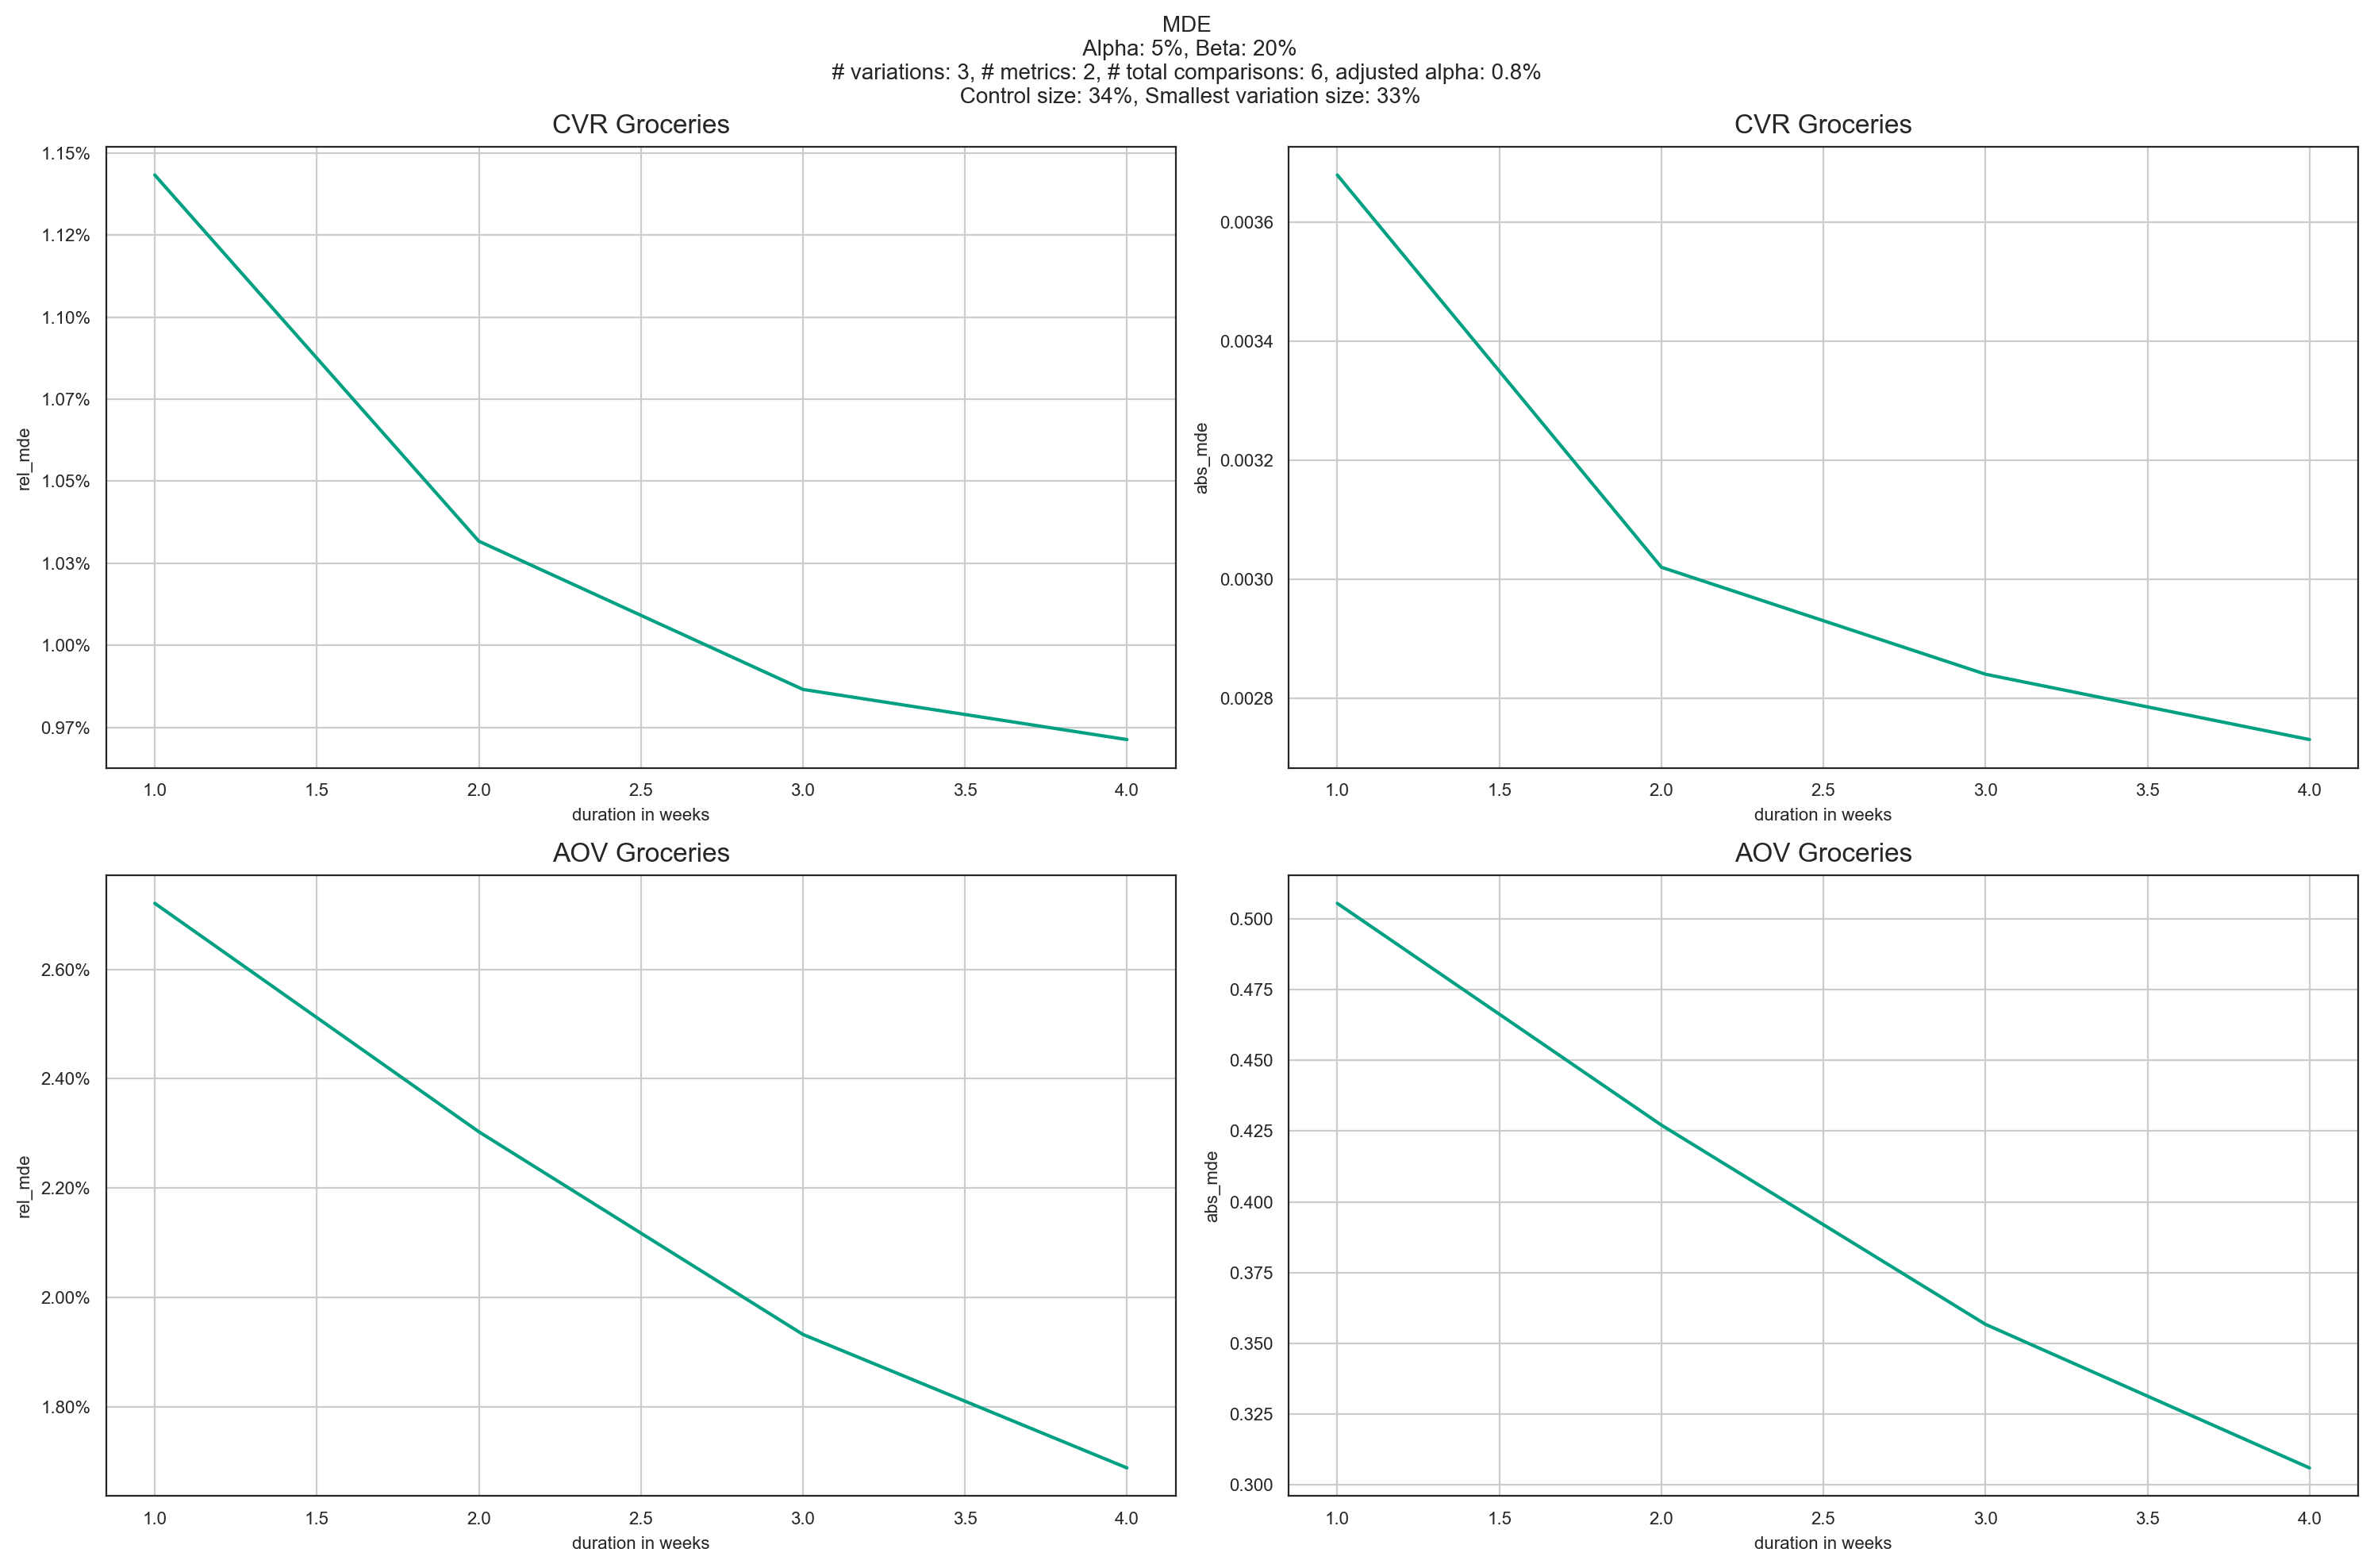

In [112]:
from matplotlib.ticker import FuncFormatter

metrics = first_launch_mde.metric_name.unique().tolist()

nrows = len(metrics)
ncols = 2

fig,axs = plt.subplots(nrows, ncols, figsize=(15,5*nrows))

for i, metric in enumerate(metrics):
    ax_left=axs[i,0]
    ax_right=axs[i,1]
    ax_left.set_title(f"{metric}", fontsize=12)
    ax_right.set_title(f"{metric}", fontsize=12)
    ax_left.set_xlabel('duration in weeks')
    ax_right.set_xlabel('duration in weeks')
    vals = ax_left.get_yticks()
    ax_left.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
    ax_right.set_title(f"{metric}", fontsize=12)
    sns.lineplot(data=first_launch_mde.query(f"metric_name=='{metric}'"), x='duration', y='rel_mde', ax=ax_left)
    sns.lineplot(data=first_launch_mde.query(f"metric_name=='{metric}'"), x='duration', y='abs_mde', ax=ax_right)
    
    ## add gridlines
    ax_left.grid(True)
    ax_right.grid(True)

    suptitle=f"MDE\n Alpha: {int(mde_accuracy['initial_alpha']*100)}%, Beta: {int(mde_accuracy['beta']*100)}%\n # variations: {len(variants_params.keys())}, # metrics: {len(mde_configuration['metrics_to_mde'])}, # total comparisons: {mde_accuracy['total_comparisons']}, adjusted alpha: {round(mde_accuracy['alpha'],3)*100}% \n Control size: {int(variants_params['control']*100)}%, Smallest variation size: {int(min(list(variants_params.values())[1:])*100)}%"

    plt.suptitle(suptitle, fontsize=10)

plt.tight_layout()
plt.show()

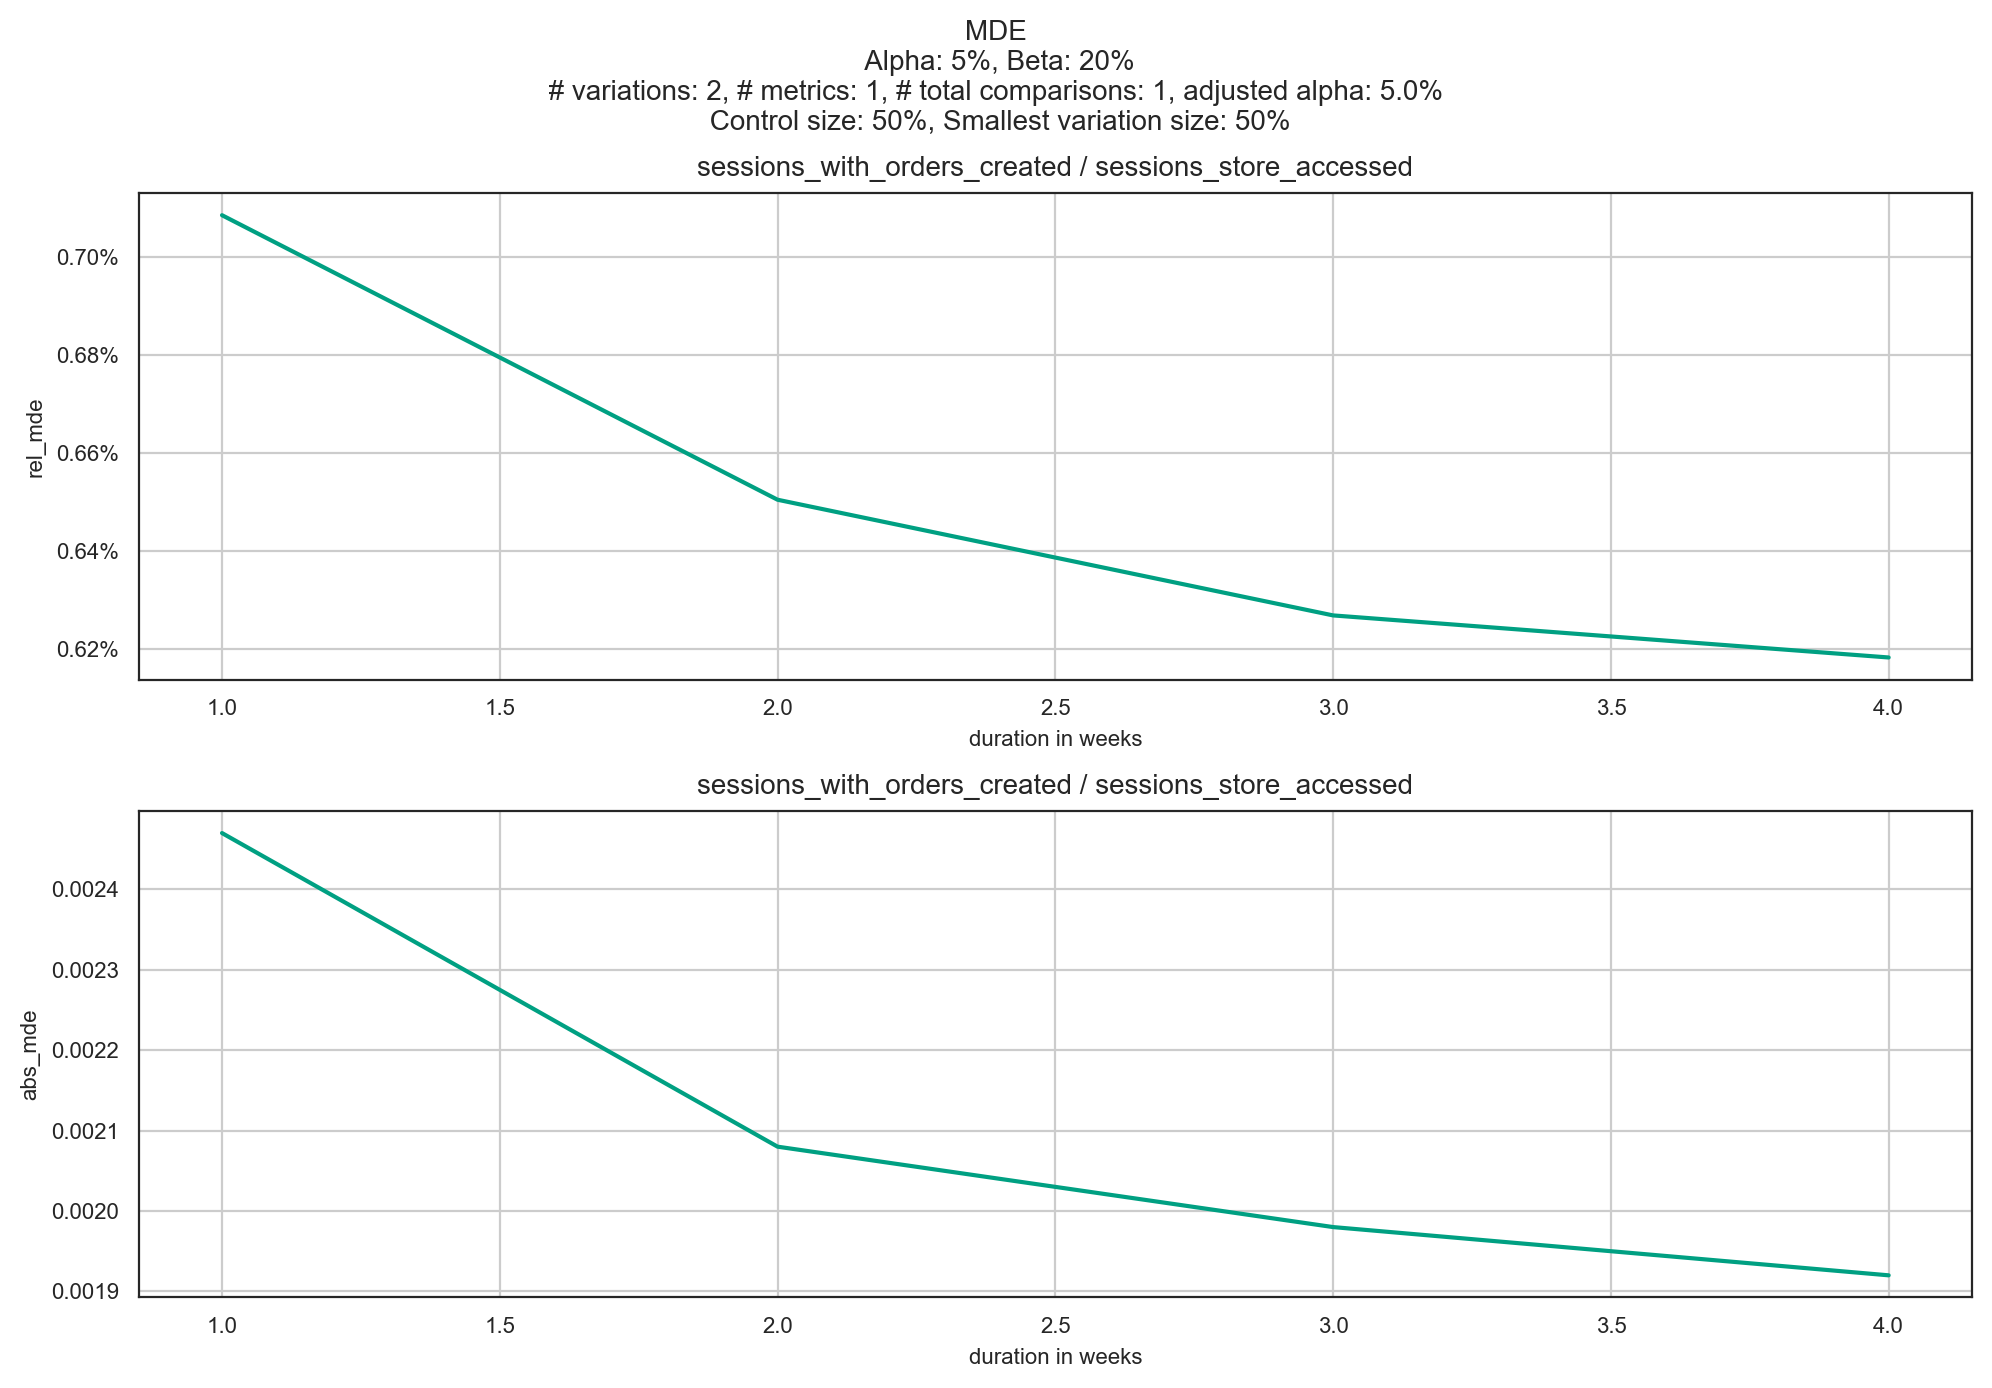

In [127]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'first_launch_mde' DataFrame and 'mde_accuracy', 'variants_params', 'mde_configuration' dictionaries are already defined

# Specify the metric you're interested in
metric = 'sessions_with_orders_created / sessions_store_accessed' 

fig, axs = plt.subplots(2, 1, figsize=(10, 7))  

ax_left = axs[0]
ax_right = axs[1]
ax_left.set_title(f"{metric}", fontsize=10)
ax_right.set_title(f"{metric}", fontsize=10)
ax_left.set_xlabel('duration in weeks')
ax_right.set_xlabel('duration in weeks')
vals = ax_left.get_yticks()
ax_left.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
sns.lineplot(data=first_launch_mde.query(f"metric_name=='{metric}'"), x='duration', y='rel_mde', ax=ax_left)
sns.lineplot(data=first_launch_mde.query(f"metric_name=='{metric}'"), x='duration', y='abs_mde', ax=ax_right)

## add gridlines
ax_left.grid(True)
ax_right.grid(True)

suptitle=f"MDE\n Alpha: {int(mde_accuracy['initial_alpha']*100)}%, Beta: {int(mde_accuracy['beta']*100)}%\n # variations: {len(variants_params.keys())}, # metrics: 1, # total comparisons: {mde_accuracy['total_comparisons']}, adjusted alpha: {round(mde_accuracy['alpha'],3)*100}% \n Control size: {int(variants_params['control']*100)}%, Smallest variation size: {int(min(list(variants_params.values())[1:])*100)}%"

plt.suptitle(suptitle, fontsize=10)

plt.tight_layout()
plt.show()